In [10]:

from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import fetch_california_housing

path="../../data/"

NameError: name 'path' is not defined

In [5]:
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

In [6]:
print("Training MLPRegressor...")
tic = time()
est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))


Training MLPRegressor...
done in 7.220s
Test R2 score: 0.81


In [7]:
print("Training GradientBoostingRegressor...")
tic = time()
est = HistGradientBoostingRegressor()
est.fit(X_train, y_train)
print("done in {:.3f}s".format(time() - tic))
print("Test R2 score: {:.2f}".format(est.score(X_test, y_test)))

Training GradientBoostingRegressor...
done in 1.034s
Test R2 score: 0.85


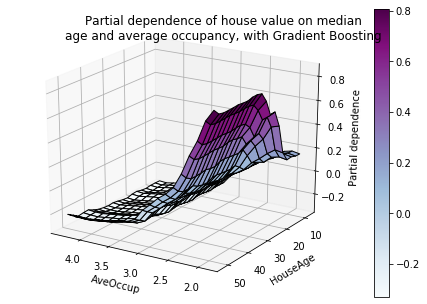

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()

features = ('AveOccup', 'HouseAge')
pdp, axes = partial_dependence(est, X_train, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()

In [11]:
AD_model_full=pd.read_pickle('%s%s' % (path,'AD_model_full.p'))


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import shap
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
path="../../data/"

import matplotlib.pyplot as plt
from scipy import interp

from sklearn.tree import DecisionTreeClassifier


from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc
from itertools import cycle
from scipy import interp
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import SMOTE
plt.style.use('ggplot')

'''
Helper function to find out columns containing specific text
'''
def findcols(df,text):
    return [col for col in df.columns if text in col]

import re
def findcols_com(strs,df):
    selcols=[col for col in df.columns if re.search(strs,col)]
    return selcols

def varstodrop(df,strs,defvars):
    selcols=[col for col in df.columns if re.search(strs,col)]
    selcols=np.append(selcols,defvars)
    return selcols

Using TensorFlow backend.


In [13]:
drpvars1='AD|hospital_episode_type_f41231_General\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|\
history_of_psychiatric|carer_support|sunlamp|answered_sexual'


drpvarsapoe='AD|hospital_episode_type_f41231_General\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|APOE|Genotype'


drvarsdef=['DIAB','DIAB_bef','EPIL','CERVASC','PD','CERVASC_bef']

drpvarssurv='AD|DIAB|EPIL|CERVASC_bef|spells_in_hospital_f41235|\
hospital_episode_type_f41231_General episode|genotype_measurement_batch_f2200|consultant\
|Unknown|Not at all'



config = dict(scale_pos_weight = 1,max_depth=3,smote=1)

In [14]:
mod_xgb=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
           max_delta_step=0, max_depth=config['max_depth'], min_child_weight=1, missing=None,
           n_estimators=60, n_jobs=4, nthread=4, objective='binary:logistic',
           random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=config['scale_pos_weight'],
           seed=42, silent=None, subsample=1, verbosity=1)

In [15]:
dropvars_full=varstodrop(AD_model_full,drpvars1,drvarsdef)

In [18]:
X = AD_model_full.drop(columns=dropvars_full)
y = AD_model_full['AD']

In [26]:
X.columns=X.columns.str.replace(',','')
X.columns=X.columns.str.replace('<','')
X.columns=X.columns.str.replace('>','')
X.columns=X.columns.str.replace('[','')
X.columns=X.columns.str.replace(']','')

In [27]:
mod_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=60, n_jobs=4,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [31]:
findcols(X,'Age')

['method_of_recording_time_when_noncancer_illness_first_diagnosed_f20013_Age at event',
 'method_of_recording_time_when_operation_occurred_f20014_Age at event',
 'Age_Today']

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

features = ('AveOccup', 'HouseAge')
pdp, axes = partial_dependence(mod_xgb, X, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()